# Image Segmentation in 3D

Image segmentation in 3D is challenging for several reasons: In many microscopy imaging techniques, image quality varies in space: For example intensity and/or contrast degrades the deeper you image inside a sample. Furthermore, touching nuclei are hard to differentiate in an automated way. Last but not least, anisotropy is difficult to handle depending on the applied algorithms and respective given parameters. Some algorithms, like the [Voronoi-Otsu-Labeling](https://github.com/clEsperanto/pyclesperanto_prototype/blob/master/demo/segmentation/voronoi_otsu_labeling.ipynb) approach demonstrated here, only work for isotropic data.

To demonstrate the workflow, we're using cropped and resampling image data from the [Broad Bio Image Challenge](https://bbbc.broadinstitute.org/BBBC032):
Ljosa V, Sokolnicki KL, Carpenter AE (2012). Annotated high-throughput microscopy image sets for validation. Nature Methods 9(7):637 / doi. PMID: 22743765 PMCID: PMC3627348. Available at http://dx.doi.org/10.1038/nmeth.2083

We start by importing the various packages and initialise the device we want to use. 

In [3]:
from skimage.io import imread
import matplotlib.pyplot as plt
import pyclesperanto as cle

cle.select_device()

(OpenCL) NVIDIA GeForce RTX 4090 (OpenCL 3.0 CUDA)
	Vendor:                      NVIDIA Corporation
	Driver Version:              535.216.01
	Device Type:                 GPU
	Compute Units:               128
	Global Memory Size:          24217 MB
	Maximum Object Size:         6054 MB
	Max Clock Frequency:         2625 MHz
	Image Support:               Yes

Next, we open our example image and configuring an interesting sub-region.

In [4]:
input_image = imread("../data/BBBC032_v1_dataset/BMP4blastocystC3-cropped_resampled_8bit.tif")

voxel_size_x = 0.202
voxel_size_y = 0.202
voxel_size_z = 1

Before segmenting the image, need to push it to GPU memory. For visualisation purposes we show X-, Y- and Z-projections ([read more about projections and how to inspect 3D data](https://github.com/clEsperanto/pyclesperanto_prototype/blob/master/demo/basics/inspecting_3d_images.ipynb)):

array([[[19, 19, 19, ..., 19, 18, 19],
        [19, 19, 20, ..., 19, 19, 18],
        [19, 19, 20, ..., 19, 19, 18],
        ...,
        [ 7,  9,  8, ...,  5,  5,  5],
        [ 8,  8,  8, ...,  5,  5,  6],
        [ 7,  8,  8, ...,  5,  5,  5]],

       [[18, 19, 19, ..., 18, 18, 18],
        [19, 18, 19, ..., 18, 18, 18],
        [19, 19, 19, ..., 18, 18, 19],
        ...,
        [ 8,  8,  8, ...,  5,  5,  4],
        [ 7,  8,  8, ...,  6,  5,  4],
        [ 8,  8,  7, ...,  5,  5,  5]],

       [[18, 18, 19, ..., 18, 18, 18],
        [18, 18, 19, ..., 18, 18, 18],
        [17, 18, 18, ..., 18, 18, 18],
        ...,
        [ 7,  8,  8, ...,  5,  5,  5],
        [ 7,  8,  8, ...,  5,  5,  5],
        [ 8,  8,  7, ...,  5,  5,  4]],

       ...,

       [[ 0,  1,  1, ...,  2,  1,  2],
        [ 0,  1,  1, ...,  2,  2,  2],
        [ 1,  1,  1, ...,  2,  2,  2],
        ...,
        [ 0,  1,  1, ...,  1,  1,  2],
        [ 0,  1,  1, ...,  2,  2,  1],
        [ 0,  0,  1, ...,  2,  2,  1]],

       [[ 1,  1,  1, ...,  2,  2,  2],
        [ 1,  1,  1, ...,  2,  2,  2],
        [ 1,  1,  2, ...,  2,  2,  2],
        ...,
        [ 1,  0,  1, ...,  2,  2,  2],
        [ 1,  1,  1, ...,  2,  2,  2],
        [ 1,  1,  1, ...,  2,  2,  1]],

       [[ 2,  1,  1, ...,  2,  3,  2],
        [ 1,  1,  1, ...,  2,  2,  2],
        [ 1,  1,  2, ...,  1,  2,  2],
        ...,
        [ 1,  1,  1, ...,  2,  2,  2],
        [ 1,  1,  1, ...,  2,  2,  2],
        [ 1,  0,  1, ...,  2,  2,  2]]], dtype=uint8, mtype=buffer)
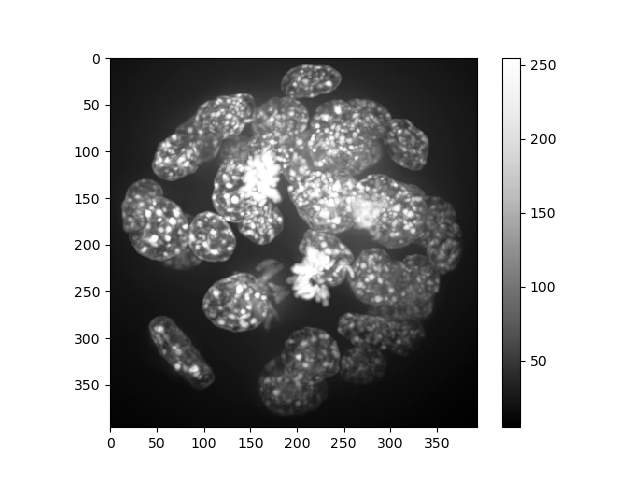
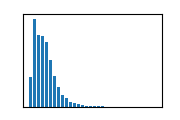

In [5]:
input_gpu = cle.push(input_image)
input_gpu

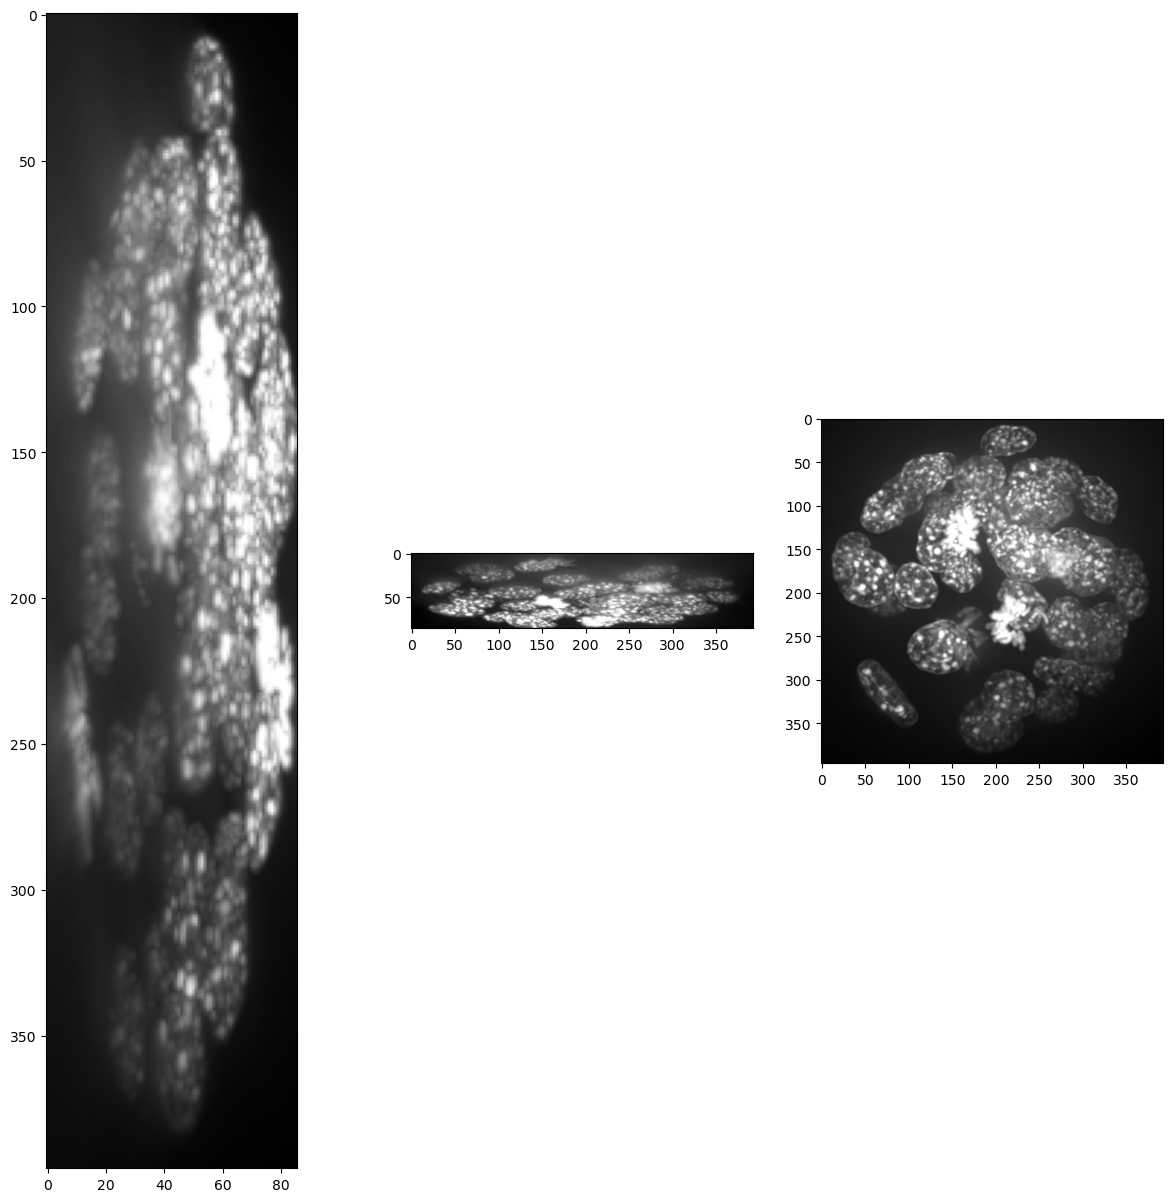

(86, 396, 393)


In [6]:
def show(image_to_show, labels=False):
    """
    This function generates three projections: in X-, Y- and Z-direction and shows them.
    """
    projection_x = cle.maximum_x_projection(image_to_show)
    projection_y = cle.maximum_y_projection(image_to_show)
    projection_z = cle.maximum_z_projection(image_to_show)

    fig, axs = plt.subplots(1, 3, figsize=(15, 15))
    axs[0].imshow(projection_x, cmap='prism' if labels else 'gray')
    axs[1].imshow(projection_y, cmap='prism' if labels else 'gray')
    axs[2].imshow(projection_z, cmap='prism' if labels else 'gray')
    plt.show()

show(input_gpu)
print(input_gpu.shape)

Obviously, voxel size is not isotropic. Thus, we scale the image with the voxel size used as scaling factor to get an image stack with isotropic voxels.

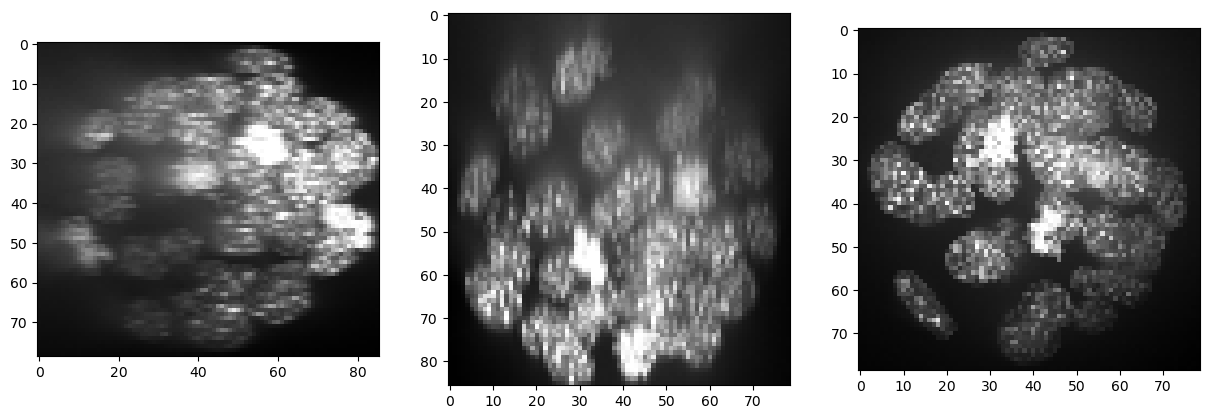

(86, 79, 79)


In [7]:
resampled = cle.create([int(input_gpu.shape[0] * voxel_size_z), int(input_gpu.shape[1] * voxel_size_y), int(input_gpu.shape[2] * voxel_size_x)])
cle.scale(input_gpu, resampled, factor_x=voxel_size_x, factor_y=voxel_size_y, factor_z=voxel_size_z, centered=False)

show(resampled)
print(resampled.shape)

## Intensity and background correction
As we can see, intensity is decreasing in Z-direction (from slice to slice) and contrast as well. At least the intensity decay can be corrected. In [CLIJx](https://github.com/clij/clijx), this method is known as [equalize_mean_intensities_of_slices.](https://clij.github.io/clij2-docs/reference_equalizeMeanIntensitiesOfSlices)

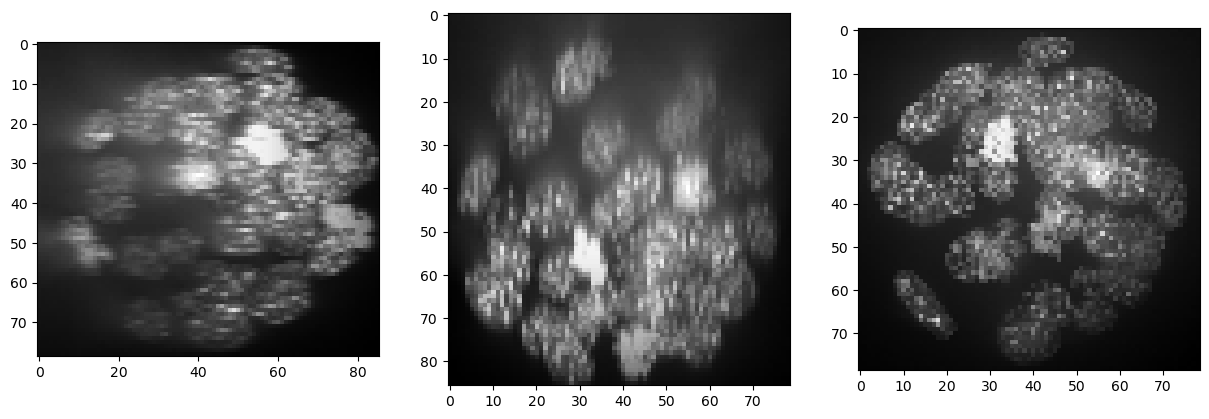

In [8]:
equalized_intensities_stack = cle.create_like(resampled)
a_slice = cle.create([resampled.shape[1], resampled.shape[2]])

num_slices = resampled.shape[0]
mean_intensity_stack = cle.mean_of_all_pixels(resampled)

corrected_slice = None
for z in range(0, num_slices):
    # get a single slice out of the stack
    cle.copy_slice(resampled, a_slice, z)
    # measure its intensity
    mean_intensity_slice = cle.mean_of_all_pixels(a_slice)
    # correct the intensity
    correction_factor = mean_intensity_slice/mean_intensity_stack
    corrected_slice = cle.multiply_image_and_scalar(a_slice, corrected_slice, correction_factor)
    # copy slice back in a stack
    cle.copy_slice(corrected_slice, equalized_intensities_stack, z)

show(equalized_intensities_stack)

Furthermore, background intensity appears to increase, potentially a result if more scattering deep in the sample. We can compensate for that by using a background subtraction technique:

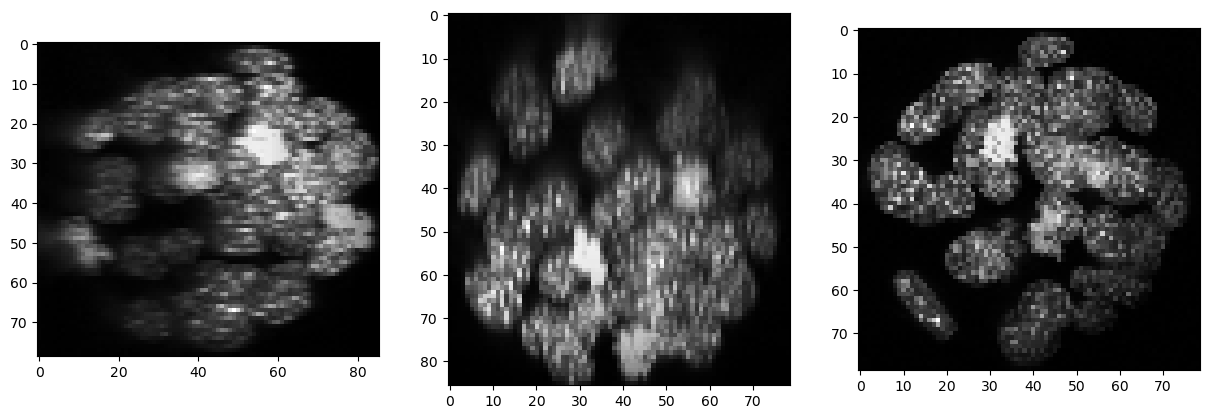

In [9]:
backgrund_subtracted = cle.top_hat_box(equalized_intensities_stack, radius_x=5, radius_y=5, radius_z=5)
show(backgrund_subtracted)

## Segmentation


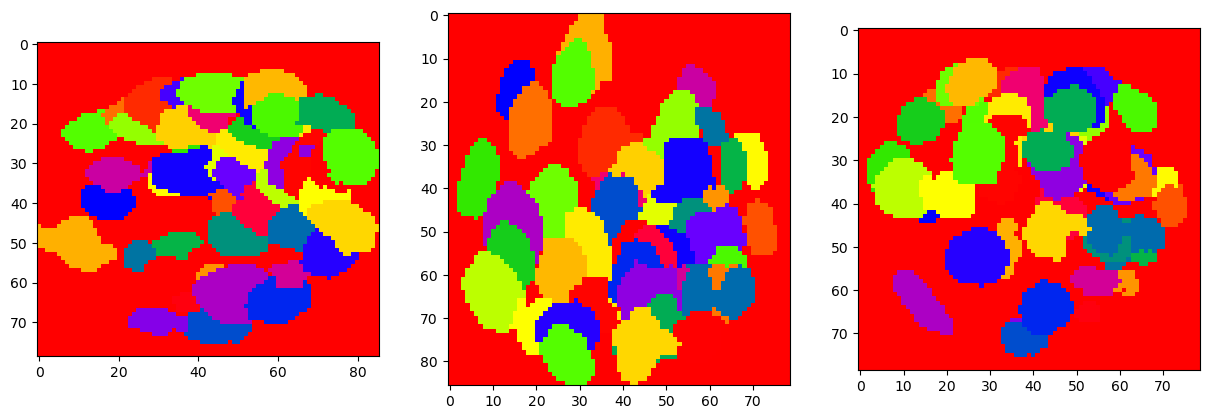

In [10]:
segmented = cle.voronoi_otsu_labeling(backgrund_subtracted, spot_sigma=3, outline_sigma=1)
show(segmented, labels=True)

As segmentation results are hard to inspect in 3D, we generate an image stack with the original intensities + outlines of the segmentation. We show this stack for a couple of slices.

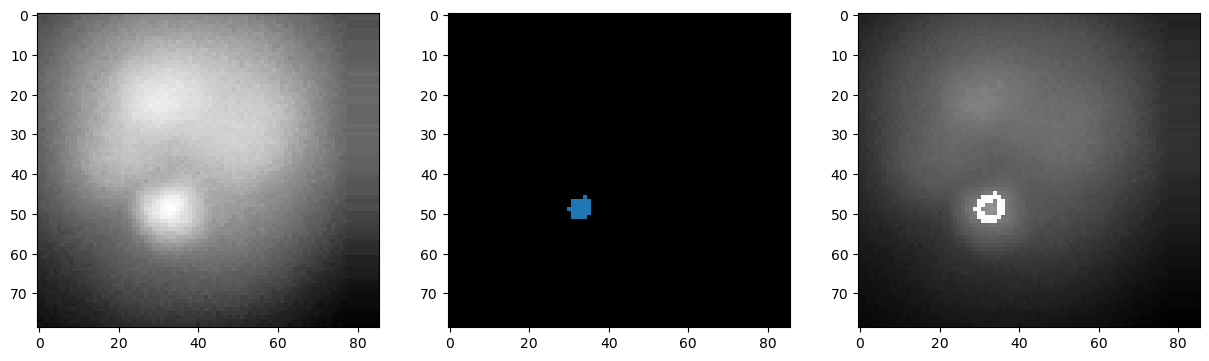

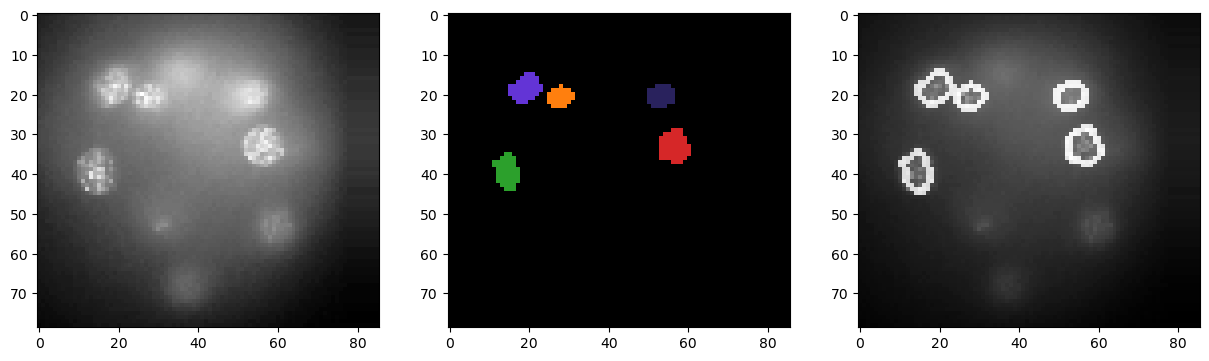

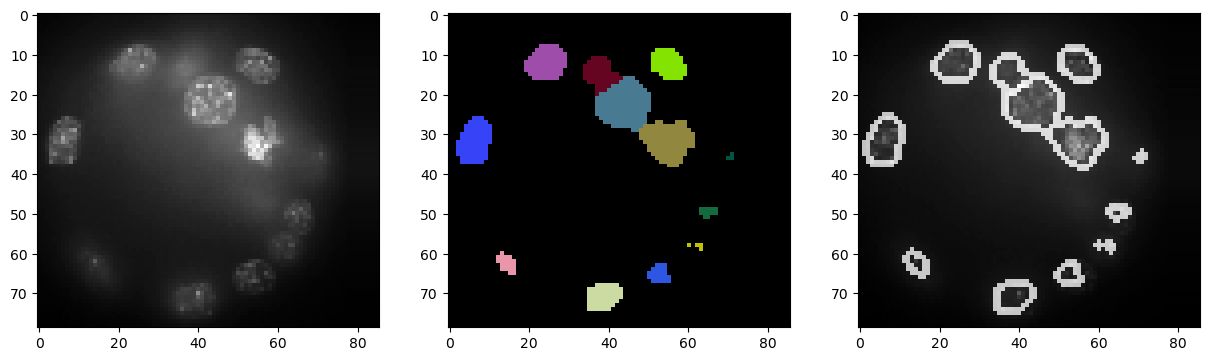

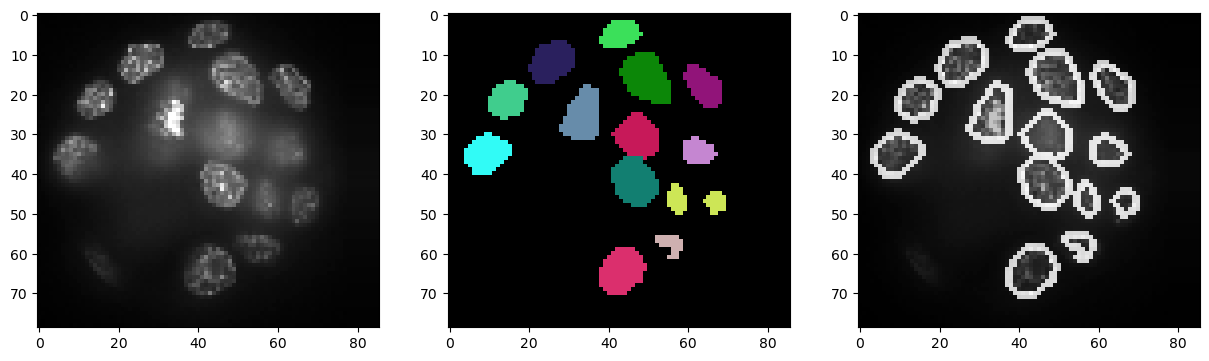

In [11]:
a_slice = cle.create([resampled.shape[1], resampled.shape[0]])
segmented_slice = cle.create([resampled.shape[1], resampled.shape[0]])

for z in range(0, resampled.shape[2], 20):
    label_outlines = None
    combined = None

    # get a single slice from the intensity image and the segmented label image
    cle.copy_slice(resampled, a_slice, z)
    cle.copy_slice(segmented, segmented_slice, z)

    # determine outlines around labeled objects
    label_outlines = cle.detect_label_edges(segmented_slice, label_outlines)

    # combine both images
    outline_intensity_factor = cle.maximum_of_all_pixels(a_slice)
    combined = cle.add_images_weighted(a_slice, label_outlines, combined, 1.0, outline_intensity_factor)

    # visualisation
    fig, axs = plt.subplots(1, 3, figsize=(15, 15))
    cle.imshow(a_slice, plot=axs[0])
    cle.imshow(segmented_slice, plot=axs[1], labels=True)
    cle.imshow(combined, plot=axs[2])

## Visualization in 3D
For actual visualization in 3D you can also use [napari](https://napari.org/).

In [15]:
# start napari
import napari
viewer = napari.Viewer()

# show images
viewer.add_image(cle.pull(resampled))
viewer.add_image(cle.pull(equalized_intensities_stack))
viewer.add_labels(cle.pull(segmented))

<Labels layer 'Labels' at 0x75bf2407a060>

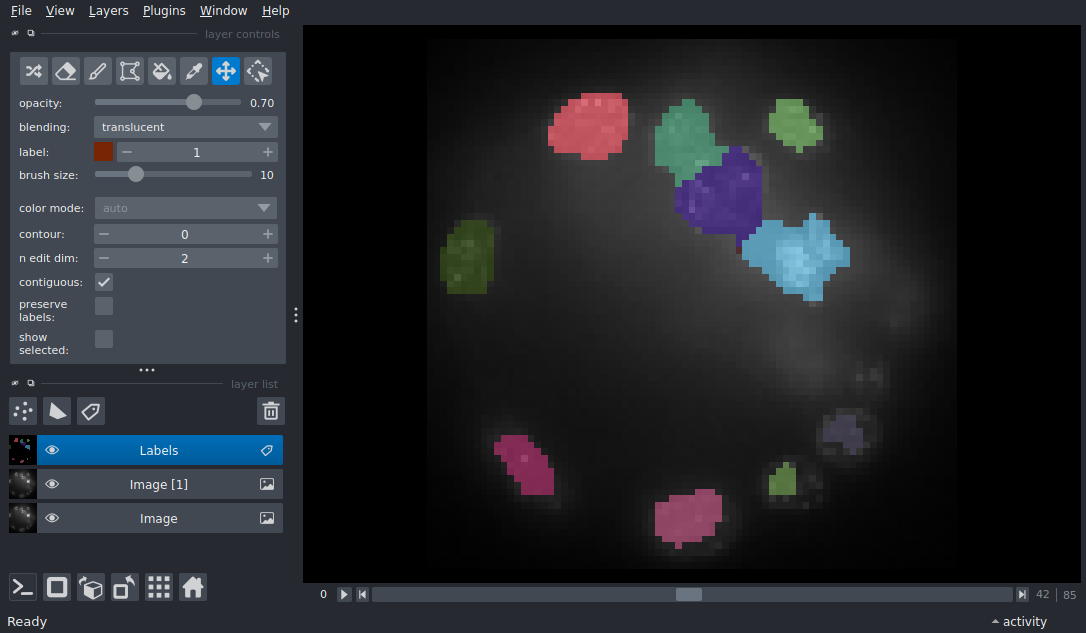

In [16]:
from napari.utils import nbscreenshot
nbscreenshot(viewer)

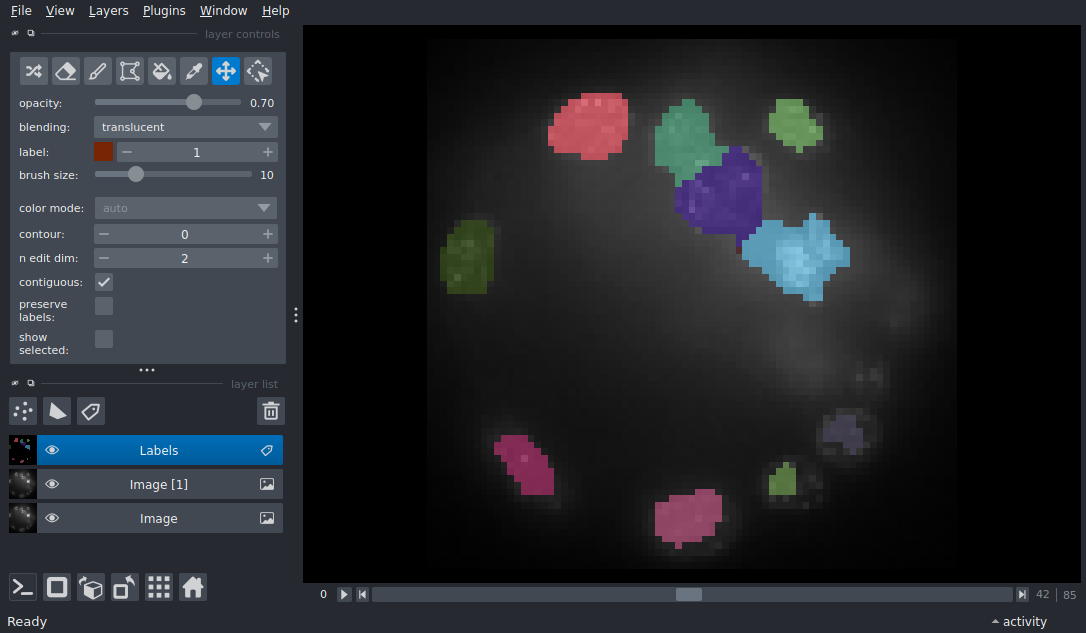

In [17]:
nbscreenshot(viewer)

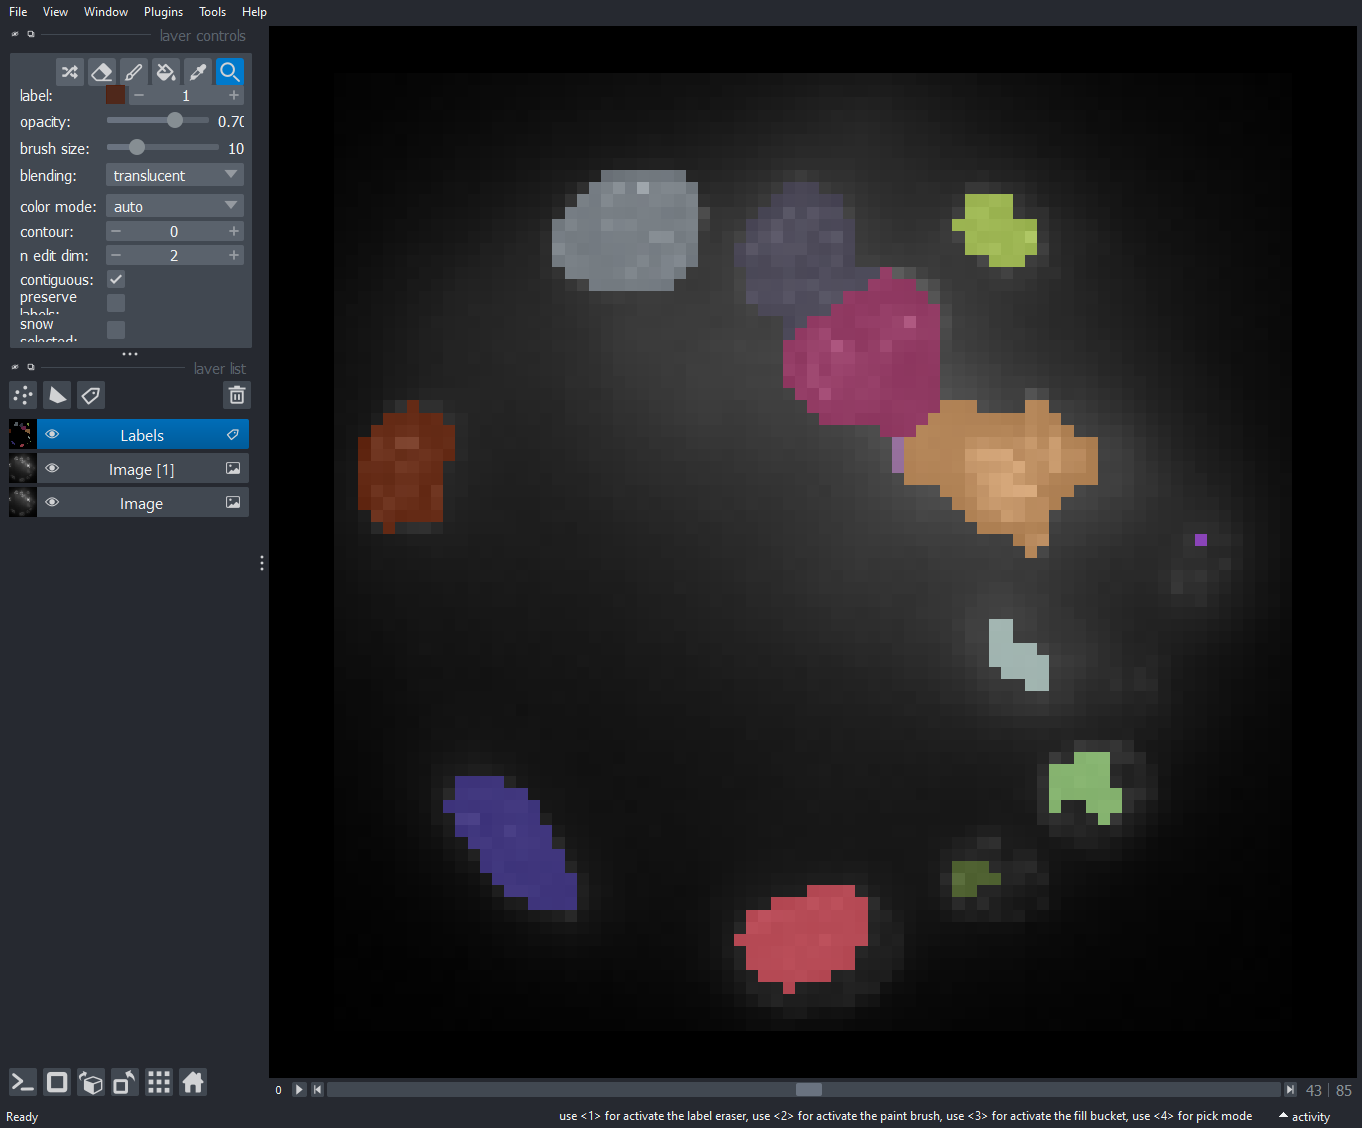

In [13]:
nbscreenshot(viewer)